## 1. Introduction



In [30]:
import numpy as np 
import pandas as pd 

import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

from sklearn import linear_model
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [36]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
labels = pd.read_csv('submission_2.csv')
print(train.info())
train.describe()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [39]:
y = train.Survived
y_test = labels.Survived
train.drop(['Survived'], 1, inplace=True)

combined = train.append(test)
combined.reset_index(inplace=True)
combined.drop(['index', 'PassengerId'], inplace=True, axis=1)
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    1309 non-null   int64  
 1   Name      1309 non-null   object 
 2   Sex       1309 non-null   object 
 3   Age       1046 non-null   float64
 4   SibSp     1309 non-null   int64  
 5   Parch     1309 non-null   int64  
 6   Ticket    1309 non-null   object 
 7   Fare      1308 non-null   float64
 8   Cabin     295 non-null    object 
 9   Embarked  1307 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 102.4+ KB


In [4]:
Title_Dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Dona": "Mrs",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty"
}

title_dummies = pd.get_dummies(combined['Title'], prefix='Title')
combined = pd.concat([combined, title_dummies], axis=1)

In [5]:
grouped_train = combined.iloc[:891].groupby(['Sex','Pclass','Title'])
grouped_median_train = grouped_train.median()
grouped_median_train = grouped_median_train.reset_index()[['Sex', 'Pclass', 'Title', 'Age']]

def fill_age(row):
    condition = (
        (grouped_median_train['Sex'] == row['Sex']) & 
        (grouped_median_train['Title'] == row['Title']) & 
        (grouped_median_train['Pclass'] == row['Pclass'])
    ) 
    return grouped_median_train[condition]['Age'].values[0]

combined['Age'] = combined.apply(lambda row: fill_age(row) if np.isnan(row['Age']) else row['Age'], axis=1)
combined.drop('Title', inplace=True, axis=1)
combined.drop('Name', inplace=True, axis=1)

In [6]:
combined.Fare.fillna(combined.iloc[:891].Fare.mean(), inplace=True)
combined.Embarked.fillna('S', inplace=True)
emb_dummies = pd.get_dummies(combined['Embarked'], prefix='Embarked')
combined = pd.concat([combined, emb_dummies], axis=1)
combined.drop('Embarked', inplace=True, axis=1)

In [7]:
combined.Cabin.fillna('U', inplace=True)
    
combined['Cabin'] = combined['Cabin'].map(lambda c: c[0])

cabin_dummies = pd.get_dummies(combined['Cabin'], prefix='Cabin')
combined = pd.concat([combined, cabin_dummies], axis=1)
combined.drop('Cabin', inplace=True, axis=1)

In [8]:
def cleanTicket(ticket):
    ticket = ticket.replace('.', '')
    ticket = ticket.replace('/', '')
    ticket = ticket.split()
    ticket = map(lambda t : t.strip(), ticket)
    ticket = list(filter(lambda t : not t.isdigit(), ticket))
    if len(ticket) > 0:
        return ticket[0]
    else: 
        return 'XXX'

combined['Ticket'] = combined['Ticket'].map(cleanTicket)

tickets_dummies = pd.get_dummies(combined['Ticket'], prefix='Ticket')
combined = pd.concat([combined, tickets_dummies], axis=1)
combined.drop('Ticket', inplace=True, axis=1)

In [9]:
combined['FamilySize'] = combined['Parch'] + combined['SibSp'] + 1
    
combined['Singleton'] = combined['FamilySize'].map(lambda s: 1 if s == 1 else 0)
combined['SmallFamily'] = combined['FamilySize'].map(lambda s: 1 if 2 <= s <= 4 else 0)
combined['LargeFamily'] = combined['FamilySize'].map(lambda s: 1 if 5 <= s else 0)


In [10]:
combined['Sex'] = combined['Sex'].map({'male':1, 'female':0})
class_dummies = pd.get_dummies(combined['Pclass'], prefix='Pclass')
combined = pd.concat([combined, class_dummies], axis=1)
combined.drop('Pclass', inplace=True, axis=1)

,Sex,Age,SibSp,Parch,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,...,Ticket_WC,Ticket_WEP,Ticket_XXX,FamilySize,Singleton,SmallFamily,LargeFamily,Pclass_1,Pclass_2,Pclass_3
0,1,22.0,1,0,7.2500,0,0,1,0,0,...,0,0,0,2,0,1,0,0,0,1
1,0,38.0,1,0,71.2833,0,0,0,1,0,...,0,0,0,2,0,1,0,1,0,0
2,0,26.0,0,0,7.9250,0,1,0,0,0,...,0,0,0,1,1,0,0,0,0,1
3,0,35.0,1,0,53.1000,0,0,0,1,0,...,0,0,1,2,0,1,0,1,0,0
4,1,35.0,0,0,8.0500,0,0,1,0,0,...,0,0,1,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1,26.0,0,0,8.0500,0,0,1,0,0,...,0,0,0,1,1,0,0,0,0,1
1305,0,39.0,0,0,108.9000,0,0,0,1,0,...,0,0,0,1,1,0,0,1,0,0
1306,1,38.5,0,0,7.2500,0,0,1,0,0,...,0,0,0,1,1,0,0,0,0,1
1307,1,26.0,0,0,8.0500,0,0,1,0,0,...,0,0,1,1,1,0,0,0,0,1


In [15]:
X = combined.iloc[:891]
X_test = combined.iloc[891:]

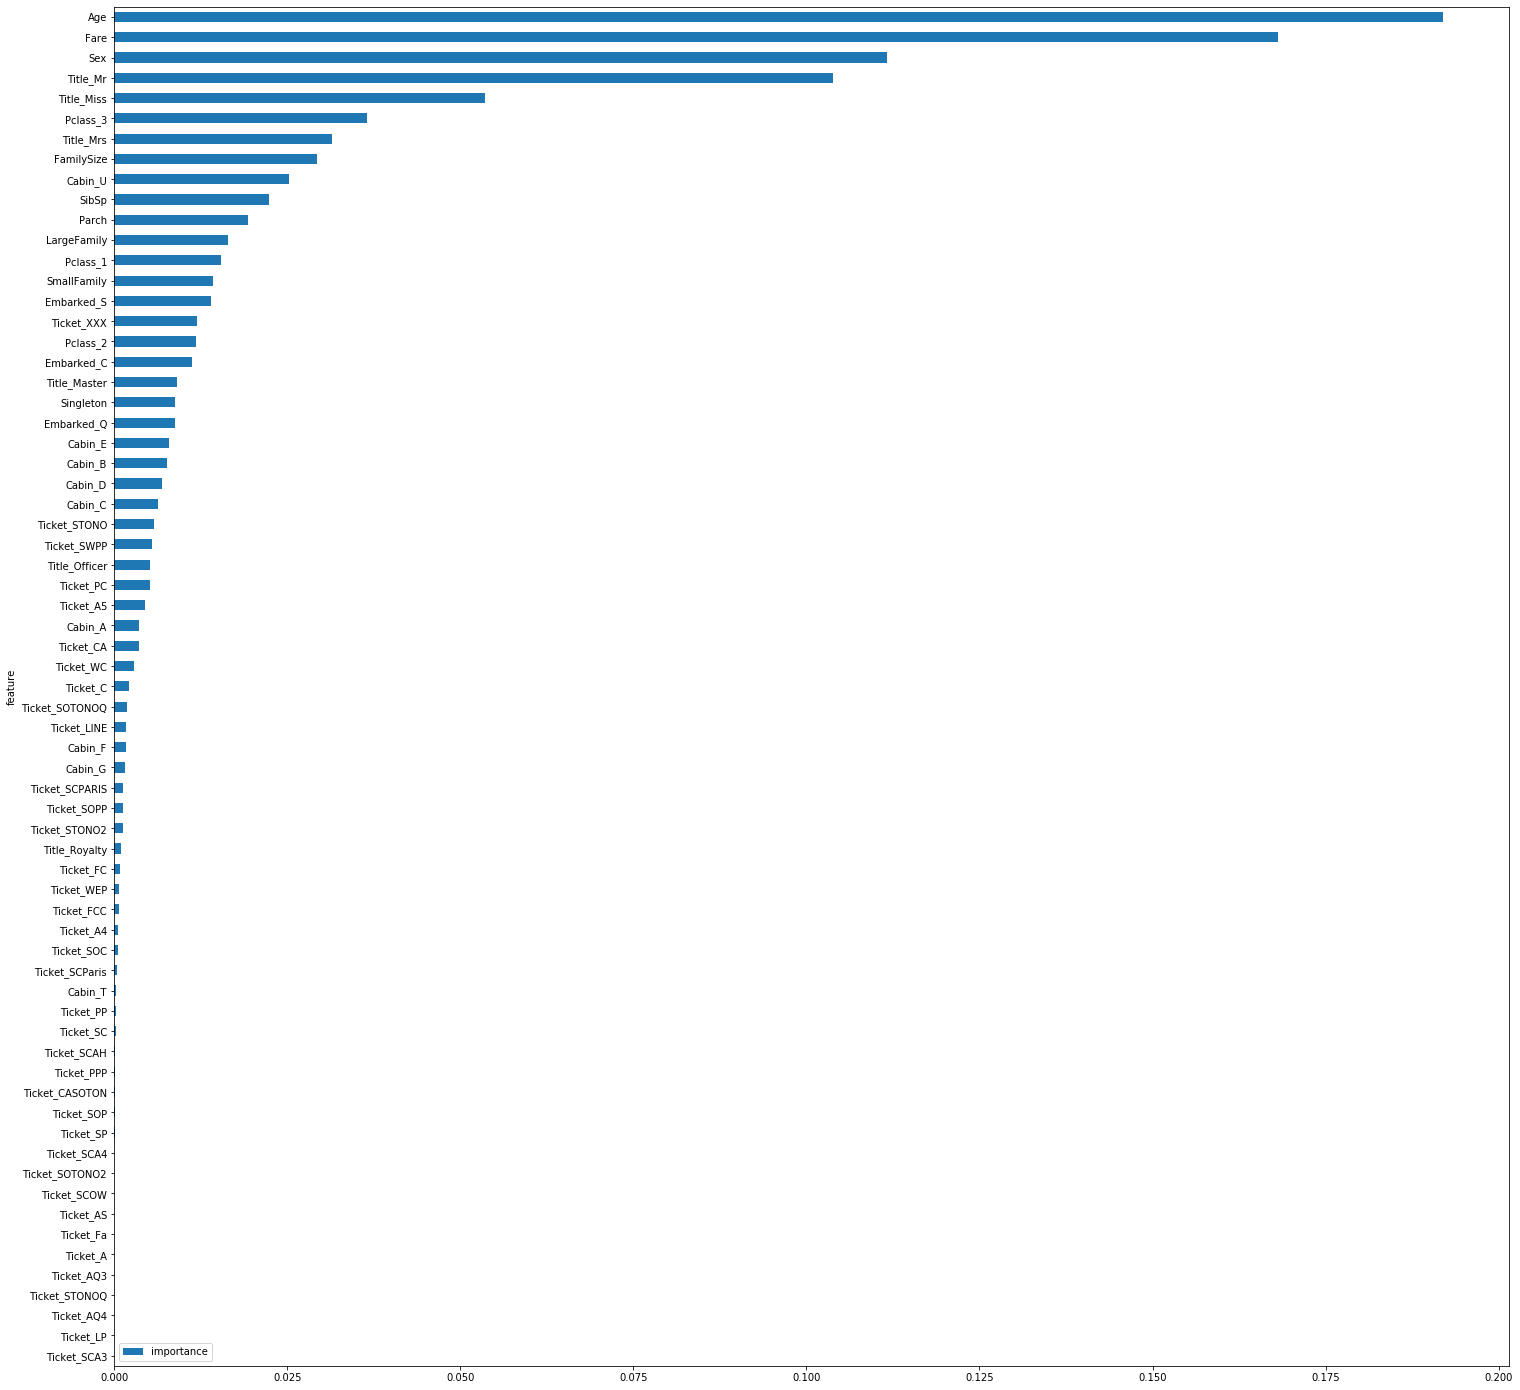

In [28]:
clf = RandomForestClassifier(n_estimators=50, max_features='sqrt')
clf = clf.fit(X, y)

features = pd.DataFrame()
features['feature'] = X.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

features.plot(kind='barh', figsize=(25, 25))


In [31]:
model = SelectFromModel(clf, prefit=True)
X_reduced = model.transform(X)
print(X_reduced.shape)

X_test_reduced = model.transform(X_test)
print(X_test_reduced.shape)

(891, 13)
(418, 13)


In [40]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
classifiers = []
classifiers.append(LogisticRegression(random_state = 0))
classifiers.append(KNeighborsClassifier())
classifiers.append(SVC(random_state=0))
classifiers.append(DecisionTreeClassifier(random_state=0))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=0),random_state=0,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=0))
classifiers.append(ExtraTreesClassifier(random_state=0))
classifiers.append(GradientBoostingClassifier(random_state=0))
classifiers.append(MLPClassifier(random_state=0))
classifiers.append(LinearDiscriminantAnalysis())

cv_predictions = []
cv_results = []
#models = 
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_reduced, y = y, scoring = "accuracy", cv = 10, n_jobs=4))
    model = classifier.fit(X_reduced, y)
    cv_predictions.append(round(classifier.score(X_test_reduced, y_test), 2))
    

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())


In [41]:
params_xgb = {'colsample_bylevel': 0.7, 'learning_rate': 0.03, 'max_depth': 3, 
              'n_estimators': 400, 'reg_lambda': 15, 'subsample': 0.5}
model = XGBClassifier(**params_xgb)
cv_results.append(cross_val_score(model, X_reduced, y = y, scoring = "accuracy", cv = 10, n_jobs=4))
model.fit(X_reduced, y)
cv_predictions.append(round(model.score(X_test_reduced, y_test), 2))
cv_means.append(cv_results[10].mean())
cv_std.append(cv_results[10].std())
                      

[23:49:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [42]:
cv_res = pd.DataFrame({"Predictions":cv_predictions,"CrossValMeans":cv_means,"CrossValerrors": cv_std,
                      "Algorithm":['LogisticRegression',"KNeighboors","SVC","DecisionTree","AdaBoost",
                                    "RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron",
                                    "LinearDiscriminantAnalysis", "XGBoost"]})
cv_res

,Predictions,CrossValMeans,CrossValerrors,Algorithm
0,0.78,0.820412,0.027143,LogisticRegression
1,0.62,0.723933,0.026835,KNeighboors
2,0.67,0.682472,0.050510,SVC
3,0.70,0.790125,0.037605,DecisionTree
4,0.72,0.789051,0.044593,AdaBoost
5,0.72,0.824981,0.048709,RandomForest
6,0.72,0.805893,0.047118,ExtraTrees
7,0.76,0.830549,0.036962,GradientBoosting
8,0.74,0.804707,0.028993,MultipleLayerPerceptron
9,0.77,0.826042,0.035237,LinearDiscriminantAnalysis
